<a href="https://colab.research.google.com/github/dmar10862/uoc_tipologia_y_ciclo_de_vida_de_los_datos_practica_2/blob/develop/src/UOC_M2851_DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Practica 2: Limpieza y análisis de datos**

M2851 - Tipología y ciclo de vida de los datos

Ciencia de Datos

**David Marín Sánchez**

Junio 2020

**Kaggle Competition**

[Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview)

# Librerias y funciones

https://github.com/Kaggle/kaggle-api

In [1]:
from google.colab import drive
from google.colab import auth
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation, Input, Embedding, LSTM, Masking, Bidirectional, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%%bash
# Instalar kaggle
pip install -q kaggle

# Cargar las credeciales de Kaggle
mkdir -p /root/.kaggle
cp -a "/content/drive/My Drive/Credentials/kaggle.json" /root/.kaggle/kaggle.json
ls -l /root/.kaggle

total 4
-rw------- 1 root root 64 May  9 08:42 kaggle.json


In [4]:
# Descargar dataset
%%bash
mkdir -p datasets
cd datasets
kaggle competitions download -c titanic
ls -la

train.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
total 100
drwxr-xr-x 2 root root  4096 May 14 12:53 .
drwxr-xr-x 1 root root  4096 May 14 13:07 ..
-rw-r--r-- 1 root root  3258 May 14 12:53 gender_submission.csv
-rw-r--r-- 1 root root 28629 May 14 12:53 test.csv
-rw-r--r-- 1 root root 61194 May 14 12:53 train.csv


# Cargar Datos

In [51]:
# Cargar dataset como Pandas DataFrame
df_train_orig = pd.read_csv('datasets/train.csv') 
df_train = df_train_orig.copy()
display(df_train.shape)
display(df_train.head())

(891, 12)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [52]:
# Separar las caracteristicas de la variable a estimar
X = df_train.drop(columns=['Survived'])
y = df_train[['Survived']]

display(X.shape)
display(X.head())
display(y.shape)
display(y.head())

(891, 11)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(891, 1)

,Survived
0,0
1,1
2,1
3,1
4,0


In [53]:
# Cargar dataset de test
X_test_orig = pd.read_csv('datasets/test.csv') 
X_test = X_test_orig.copy()
display(X_test.shape)
display(X_test.head())

(418, 11)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [0]:
# Deajar solo variables útiles
X = X.drop(columns=['PassengerId', 'Ticket', 'Name'])
X_test = X_test.drop(columns=['PassengerId', 'Ticket', 'Name'])

# Limpieza de datos

In [55]:
# Convertir variables en numéricas
X['Sex'], sex = pd.factorize(X['Sex'])
X['Embarked'], embarked = pd.factorize(X['Embarked'])
X['Cabin'], cabin = pd.factorize(X['Cabin'])
X['Cabin'] = X['Cabin'].replace(-1,np.nan)

display(X.head())
print(sex)
print(embarked)
print(cabin)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,0,22.0,1,0,7.2500,NaN,0
1,1,1,38.0,1,0,71.2833,0.0,1
2,3,1,26.0,0,0,7.9250,NaN,0
3,1,1,35.0,1,0,53.1000,1.0,0
4,3,0,35.0,0,0,8.0500,NaN,0


Index(['male', 'female'], dtype='object')
Index(['S', 'C', 'Q'], dtype='object')
Index(['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27', 'B78',
       'D33',
       ...
       'B102', 'B69', 'E49', 'C47', 'D28', 'E17', 'A24', 'C50', 'B42', 'C148'],
      dtype='object', length=147)


In [56]:
display(X.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,204.000000,891.000000
mean,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,66.818627,0.359147
std,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,42.495800,0.638707
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,28.750000,0.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,63.000000,0.000000
75%,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,103.250000,1.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,146.000000,2.000000


In [57]:
# Convertir variables en numéricas
X_test['Sex'], sex = pd.factorize(X_test['Sex'])
X_test['Embarked'], embarked = pd.factorize(X_test['Embarked'])
X_test['Cabin'], cabin = pd.factorize(X_test['Cabin'])
X_test['Cabin'] = X_test['Cabin'].replace(-1,np.nan)

display(X_test.head())
print(sex)
print(embarked)
print(cabin)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,0,34.5,0,0,7.8292,NaN,0
1,3,1,47.0,1,0,7.0000,NaN,1
2,2,0,62.0,0,0,9.6875,NaN,0
3,3,0,27.0,0,0,8.6625,NaN,1
4,3,1,22.0,1,1,12.2875,NaN,1


Index(['male', 'female'], dtype='object')
Index(['Q', 'S', 'C'], dtype='object')
Index(['B45', 'E31', 'B57 B59 B63 B66', 'B36', 'A21', 'C78', 'D34', 'D19',
       'A9', 'D15', 'C31', 'C23 C25 C27', 'F G63', 'B61', 'C53', 'D43', 'C130',
       'C132', 'C101', 'C55 C57', 'B71', 'C46', 'C116', 'F', 'A29', 'G6', 'C6',
       'C28', 'C51', 'E46', 'C54', 'C97', 'D22', 'B10', 'F4', 'E45', 'E52',
       'D30', 'B58 B60', 'E34', 'C62 C64', 'A11', 'B11', 'C80', 'F33', 'C85',
       'D37', 'C86', 'D21', 'C89', 'F E46', 'A34', 'D', 'B26', 'C22 C26',
       'B69', 'C32', 'B78', 'F E57', 'F2', 'A18', 'C106', 'B51 B53 B55',
       'D10 D12', 'E60', 'E50', 'E39 E41', 'B52 B54 B56', 'C39', 'B24', 'D28',
       'B41', 'C7', 'D40', 'D38', 'C105'],
      dtype='object')


In [58]:
display(X_test.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000,91.000000,418.000000
mean,2.265550,0.363636,30.272590,0.447368,0.392344,35.627188,34.956044,1.133971
std,0.841838,0.481622,14.181209,0.896760,0.981429,55.907576,22.081119,0.580452
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,21.000000,0.000000,0.000000,7.895800,16.500000,1.000000
50%,3.000000,0.000000,27.000000,0.000000,0.000000,14.454200,34.000000,1.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.500000,52.500000,1.000000
max,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200,75.000000,2.000000


# Valores perdidos

In [59]:
# https://scikit-learn.org/stable/modules/impute.html
# https://scikit-learn.org/dev/modules/generated/sklearn.impute.KNNImputer.html

# Se asigna a la variable imp un objeto del tipo KNNImputer
imp = KNNImputer()

# Se aplica la transformación para cada atributo
X = pd.DataFrame(imp.fit_transform(X), columns = X.columns)

# Se analiza la distribución del dataframe
display(X.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.352413,29.831710,0.523008,0.381594,32.204208,60.462177,0.359147
std,0.836071,0.477990,13.537619,1.102743,0.806057,49.693429,27.730831,0.638707
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,2.000000,0.000000,21.100000,0.000000,0.000000,7.910400,39.400000,0.000000
50%,3.000000,0.000000,28.500000,0.000000,0.000000,14.454200,60.400000,0.000000
75%,3.000000,1.000000,37.500000,1.000000,0.000000,31.000000,74.800000,1.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,146.000000,2.000000


In [60]:
# Se aplica la transformación para cada atributo
X_test = pd.DataFrame(imp.fit_transform(X_test), columns = X_test.columns)

# Se analiza la distribución del dataframe
display(X_test.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,0.363636,30.145215,0.447368,0.392344,35.560333,38.698565,1.133971
std,0.841838,0.481622,12.958460,0.896760,0.981429,55.857227,12.727057,0.580452
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,22.000000,0.000000,0.000000,7.895800,32.000000,1.000000
50%,3.000000,0.000000,27.400000,0.000000,0.000000,14.454200,40.800000,1.000000
75%,3.000000,1.000000,37.200000,1.000000,0.000000,31.471875,46.200000,1.000000
max,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200,75.000000,2.000000


# Análisis de normalidad y homogeneidad de la varianza y valores extremos

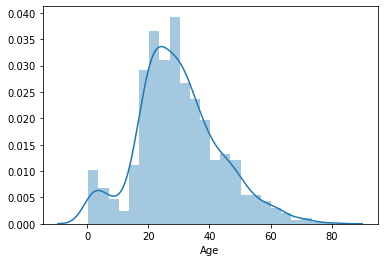

In [61]:
# Age
plot = sns.distplot(X['Age']);

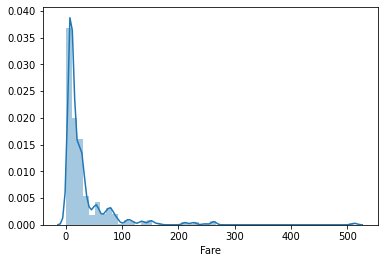

In [62]:
plot = sns.distplot(X['Fare']);

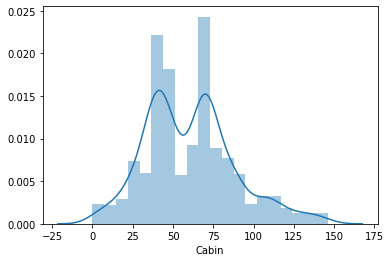

In [63]:
plot = sns.distplot(X['Cabin']);

# Análisis de correlación

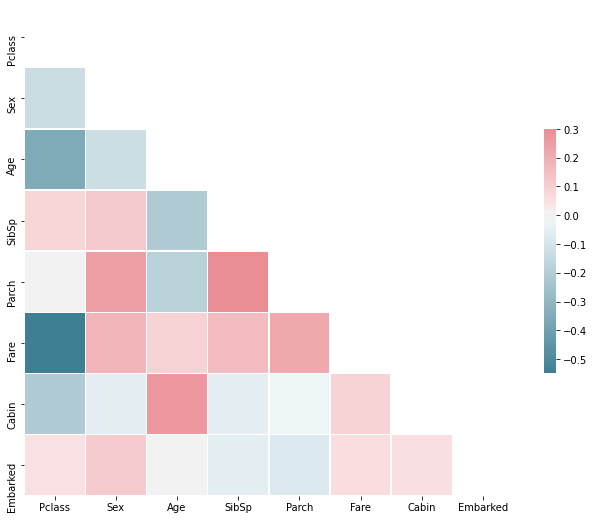

In [64]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

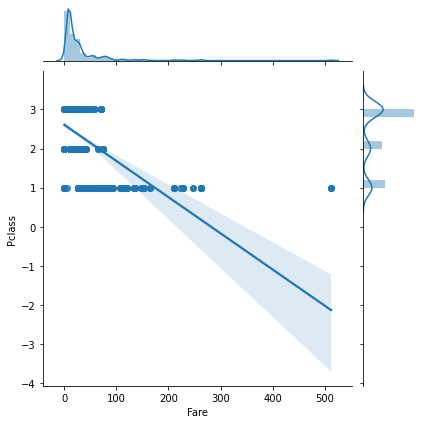

In [65]:
# https://seaborn.pydata.org/tutorial/regression.html
sns.jointplot(x="Fare", y="Pclass", kind="reg", data=X);

# Estndarizar

In [66]:
X = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)
display(X.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
count,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02
mean,-2.031048e-16,3.162453e-16,2.322310e-16,3.456519e-16,6.716164e-17,-4.373606e-17,4.256478e-16,1.171279e-16
std,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00
min,-1.566107e+00,-7.376951e-01,-2.173811e+00,-4.745452e-01,-4.736736e-01,-6.484217e-01,-2.181548e+00,-2.129160e+00
25%,-3.693648e-01,-7.376951e-01,-6.453583e-01,-4.745452e-01,-4.736736e-01,-4.891482e-01,-7.599486e-01,-5.626187e-01
50%,8.273772e-01,-7.376951e-01,-9.842634e-02,-4.745452e-01,-4.736736e-01,-3.573909e-01,-2.243433e-03,-5.626187e-01
75%,8.273772e-01,1.355574e+00,5.667611e-01,4.327934e-01,-4.736736e-01,-2.424635e-02,5.173258e-01,1.003923e+00
max,8.273772e-01,1.355574e+00,3.707924e+00,6.784163e+00,6.974147e+00,9.667167e+00,3.086307e+00,2.570464e+00


In [67]:
X_test = pd.DataFrame(StandardScaler().fit_transform(X_test), columns = X_test.columns)
display(X_test.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
count,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02
mean,-2.018587e-17,-1.859225e-17,-1.745680e-16,-1.593622e-17,-1.407699e-16,-6.075682e-17,-1.978747e-16,8.499315e-18
std,1.001198e+00,1.001198e+00,1.001198e+00,1.001198e+00,1.001198e+00,1.001198e+00,1.001198e+00,1.001198e+00
min,-1.505120e+00,-7.559289e-01,-2.315949e+00,-4.994700e-01,-4.002477e-01,-6.373919e-01,-3.044297e+00,-1.955941e+00
25%,-1.505120e+00,-7.559289e-01,-6.293168e-01,-4.994700e-01,-4.002477e-01,-4.958657e-01,-5.269554e-01,-2.310816e-01
50%,8.734819e-01,-7.559289e-01,-2.121012e-01,-4.994700e-01,-4.002477e-01,-3.783114e-01,1.653134e-01,-2.310816e-01
75%,8.734819e-01,1.322876e+00,5.450678e-01,6.169924e-01,-4.002477e-01,-7.328250e-02,5.901148e-01,-2.310816e-01
max,8.734819e-01,1.322876e+00,3.542839e+00,8.432229e+00,8.781044e+00,8.545719e+00,2.855722e+00,1.493778e+00


# Modelado

In [0]:
# ML Model train
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
def train_ml_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=1, patience=0, shuffle=True):
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    tb = TensorBoard("/tmp/TensorBoard/keras")

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=shuffle, callbacks=[es, mc, tb])

    # load the saved model
    model = load_model('best_model.h5')

    # plot training history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()
  
    # Estimate model performance
    trainScore = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
    valScore = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
  
    print('Train Loss: %.3f' % trainScore[0])
    print('Train Accuracy: %.3f' % trainScore[1])
    print('Val Loss: %.3f' % valScore[0])
    print('Val Accuracy: %.3f' % valScore[1])
  
    return model

In [0]:
# Entrenar Red neuronal densa
# https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
# https://www.kaggle.com/parthsuresh/binary-classifier-using-keras-97-98-accuracy
# @tf.function
def dense_nn(X, y, epochs=100, batch_size=1, lr=0.0001, patience=10, shuffle=True, stateful=False): 
  # Split test y val
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

  # Dimensiones
  n_input =  X_train.shape[1]
  n_output = y_train.shape[1]
  
  model = Sequential([
      Dense(n_input, input_dim=n_input, activation='relu'),
      Dense(16, activation='relu'),
      Dense(8, activation='relu'),
      Dense(4, activation='relu'),
      Dense(n_output, activation='sigmoid')
  ])
  
  model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])

  model = train_ml_model(model, X_train, y_train, X_val, y_val, epochs, batch_size, patience, shuffle)
  
  return model, X_train, X_val, y_train, y_val

In [0]:
# ML Model predict
def predict_with_ml_model(model, X, batch_size=1):
  y_pred = (model.predict(X, batch_size=batch_size) > 0.5).astype("int32")

  return y_pred

Epoch 1/100
801/801 [==============================] - 1s 2ms/step - loss: 0.6821 - accuracy: 0.5418 - val_loss: 0.6588 - val_accuracy: 0.7222
Epoch 2/100
801/801 [==============================] - 1s 2ms/step - loss: 0.6445 - accuracy: 0.6779 - val_loss: 0.5945 - val_accuracy: 0.7556
Epoch 3/100
801/801 [==============================] - 1s 1ms/step - loss: 0.5940 - accuracy: 0.7441 - val_loss: 0.5208 - val_accuracy: 0.8000
Epoch 4/100
801/801 [==============================] - 1s 2ms/step - loss: 0.5359 - accuracy: 0.7865 - val_loss: 0.4520 - val_accuracy: 0.8667
Epoch 5/100
801/801 [==============================] - 1s 2ms/step - loss: 0.4910 - accuracy: 0.7990 - val_loss: 0.4088 - val_accuracy: 0.8556
Epoch 6/100
801/801 [==============================] - 1s 1ms/step - loss: 0.4672 - accuracy: 0.7990 - val_loss: 0.3909 - val_accuracy: 0.8556
Epoch 7/100
801/801 [==============================] - 1s 2ms/step - loss: 0.4559 - accuracy: 0.8065 - val_loss: 0.3789 - val_accuracy: 0.8556

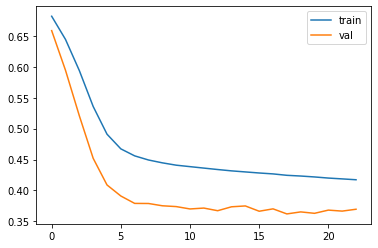

Train Loss: 0.421
Train Accuracy: 0.813
Val Loss: 0.362
Val Accuracy: 0.856


In [73]:
model, X_train, X_val, y_train, y_val = dense_nn(X, y, epochs=100, batch_size=1, lr=0.0002, patience=5)

In [74]:
# Train accuracy
y_pred = predict_with_ml_model(model, X_train)
train_acc = accuracy_score(y_train, y_pred, normalize=True)

# Val accuracy
y_pred = predict_with_ml_model(model, X_val)
val_acc = accuracy_score(y_val, y_pred, normalize=True)

# Global accuracy
y_pred = predict_with_ml_model(model, X)
acc = accuracy_score(y, y_pred, normalize=True)

print('Train Accuracy: %.3f' % train_acc)
print('Val Accuracy: %.3f' % val_acc)
print('Accuracy: %.3f' % acc)

Train Accuracy: 0.813
Val Accuracy: 0.856
Accuracy: 0.817


In [75]:
# generate predictions for test
df_pred = X_test_orig.copy()
df_pred = df_pred[['PassengerId']]
df_pred['Survived'] = predict_with_ml_model(model, X_test)
  
display(df_pred.describe())
display(df_pred.head()) 
df_pred.to_csv('submission.csv', index=False)  

,PassengerId,Survived
count,418.000000,418.000000
mean,1100.500000,0.334928
std,120.810458,0.472531
min,892.000000,0.000000
25%,996.250000,0.000000
50%,1100.500000,0.000000
75%,1204.750000,1.000000
max,1309.000000,1.000000


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [28]:
%%bash
kaggle competitions submit -c titanic -f submission.csv -m "New submission test"

403 - Your team has used its submission allowance (10 of 10). This resets at midnight UTC (5.4 hours from now).


100%|##########| 2.77k/2.77k [00:09<00:00, 295B/s]
